In [1]:
В ходе выполнения ВКР мы исследуем данные о ценах на биткоин, полученные с биржи Binance. 
    Задачи:
1) Выявить закономерности в ежедневной изменение цены относительно времени (беря разные временные интервалы)
2) Применение модели LSTM, GRU, CNN для прогнозирования временных рядов, выявим наилуджешею модель по средней ошибке 


In [2]:
#Подгружаем библиотеки

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import csv
import xml.etree.ElementTree as ET
import joblib
import ccxt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from scipy.stats import zscore
import datetime
from scipy.stats import norm



In [ ]:
Для начала исследования мы должны получить данные с биржи Binance. Для этого был создан небольшой парсер. 
Этот парсер представляет собой инструмент, который автоматически извлекает информацию из веб-сайта Binance, 
обеспечивая нам доступ к актуальным данным о торговле криптовалютами.

In [ ]:
def get_binance_bitcoin_prices():
    # Создаем объект для работы с Binance
    binance = ccxt.binance()
    # Устанавливаем таймфрейм на 1 минуту (1m)
    timeframe = '1m'
    # Получаем торговую пару
    symbol = 'BTC/USDT'

    try:
        # Рассчитываем временную метку 'since' для получения данных за последний год
        one_year_ago = datetime.datetime.now() - datetime.timedelta(days=1825)
        since = binance.parse8601(str(one_year_ago.isoformat()))

        # Создаем список для хранения данных
        bitcoin_prices = []

        # Получаем итератор для пакетного получения данных
        while since < binance.milliseconds():
            ohlcv_data = binance.fetch_ohlcv(symbol, timeframe, since, limit=1000)
            if not ohlcv_data:
                break
            since = ohlcv_data[-1][0] + 1  # Устанавливаем 'since' на следующую временную метку
            bitcoin_prices.extend([(datetime.datetime.fromtimestamp(candle[0] / 1000.0), candle[4]) for candle in ohlcv_data])

    except Exception as e:
        print(f"Ошибка при получении данных: {e}")
        return None

    return bitcoin_prices


def write_to_csv(data, filename):
    with open(filename, mode='w', newline='') as file:
        print(f'Идет запись')
        writer = csv.writer(file)
        writer.writerow(['Date', 'Price'])
        for date, price in data:
            writer.writerow([date.strftime('%Y-%m-%d %H:%M:%S'), price])


if __name__ == "__main__":
    bitcoin_prices = get_binance_bitcoin_prices()
    if bitcoin_prices is not None:
        csv_filename = 'D:/PyCharm/VKR/data/bitcoin_prices_five_years.csv'
        write_to_csv(bitcoin_prices, csv_filename)
        print(f"Data has been written to {csv_filename}")

In [ ]:
выведем информацию о наших данных за год 

In [9]:
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices_five_years.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623096 entries, 0 to 2623095
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Price   float64
dtypes: float64(1), object(1)
memory usage: 40.0+ MB


In [12]:
Прежде чем приступить к анализу данных, я решили создать три набора данных для более детального рассмотрения ежедневных закономерностей. 
Для этого я сфокусируюсь на временном периоде одного месяца, одного года и пяти лет. 
Такой подход позволит мне более детально выявить возможные закономерности в колебаниях цен.

Я решили исключить данные, лежащие за пределами пятилетнего периода, поскольку в этот период торговля крайне ограничена, 
что делает их анализ малопродуктивным. Фокусирование на более активных временных периодах поможет мне более точно выявить закономерности и тенденции, 
которые могут быть полезными для нашего исследования.

In [18]:
def Data_processing(data):
    # Рассчитаем процентное изменение цен
    data['Price_Percentage_Change'] = data['Price'].pct_change()

    # Устанавливаем начальное и конечное время
    start_time = datetime.time(0, 0)
    end_time = datetime.time(23, 59)

    # Инициализируем списки для хранения времени и вероятностей
    times = []
    positive_probabilities = []

    # Цикл для каждой минуты в выбранном времени
    message_number = 1
    
    # Проход по часам и минутам
    for hour in range(start_time.hour, end_time.hour + 1):
        for minute in range(60):
            current_time = datetime.time(hour, minute)
            specific_time_data = data[data['Date'].dt.time == current_time]
            positive_changes = (specific_time_data['Price_Percentage_Change'] > 0).mean()
            times.append(current_time.strftime('%H:%M:%S'))
            positive_probabilities.append(positive_changes)
    
            if message_number % 10 == 0:
                # Выводит результат вероятности роста или падения цены в текущее время
                if positive_changes > 0.5:
                    print(f"Время {current_time} обычно имеет положительные изменения цены с вероятностью {positive_changes * 100:.2f}%.")
                else:
                    print(f"Время {current_time} обычно имеет отрицательные изменения цены с вероятностью {positive_changes * 100:.2f}%.")
            
            # Увеличение номера текущего сообщения после каждой итерации
            message_number += 1
                
    return positive_probabilities, times

# Создаем пустой DataFrame
final_df = pd.DataFrame()

# Первый файл
data = pd.read_csv('D:/PyCharm/VKR/data/obr_data.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data_list_interest, time = Data_processing(data)
df = pd.DataFrame(time, columns=['Time'])
final_df = pd.concat([final_df, df], axis=1)
df = pd.DataFrame(data_list_interest, columns=['Monthly_data'])
final_df = pd.concat([final_df, df], axis=1)

# Второй файл
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data_list_interest, time = Data_processing(data)
df = pd.DataFrame(data_list_interest, columns=['Annual_data'])
final_df = pd.concat([final_df, df], axis=1)

# Третий файл
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices_five_years.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data_list_interest, time = Data_processing(data)
df = pd.DataFrame(data_list_interest, columns=['Data_for_5_years'])
final_df = pd.concat([final_df, df], axis=1)

# Сохраняем объединенный DataFrame в CSV файл
final_df.to_csv('D:/PyCharm/VKR/data/Probability_of_growth_2.csv', index=False)


Время 00:09:00 обычно имеет положительные изменения цены с вероятностью 52.50%.
Время 00:19:00 обычно имеет положительные изменения цены с вероятностью 55.00%.
Время 00:29:00 обычно имеет отрицательные изменения цены с вероятностью 37.50%.
Время 00:39:00 обычно имеет положительные изменения цены с вероятностью 52.50%.
Время 00:49:00 обычно имеет положительные изменения цены с вероятностью 55.00%.
Время 00:59:00 обычно имеет отрицательные изменения цены с вероятностью 50.00%.
Время 01:09:00 обычно имеет положительные изменения цены с вероятностью 62.50%.
Время 01:19:00 обычно имеет отрицательные изменения цены с вероятностью 42.50%.
Время 01:29:00 обычно имеет отрицательные изменения цены с вероятностью 45.00%.
Время 01:39:00 обычно имеет отрицательные изменения цены с вероятностью 45.00%.
Время 01:49:00 обычно имеет отрицательные изменения цены с вероятностью 37.50%.
Время 01:59:00 обычно имеет отрицательные изменения цены с вероятностью 50.00%.
Время 02:09:00 обычно имеет отрицательны

In [ ]:
выведем получившиеся данные на график с установленным шагом в 20 пунктов для читабельности графиков

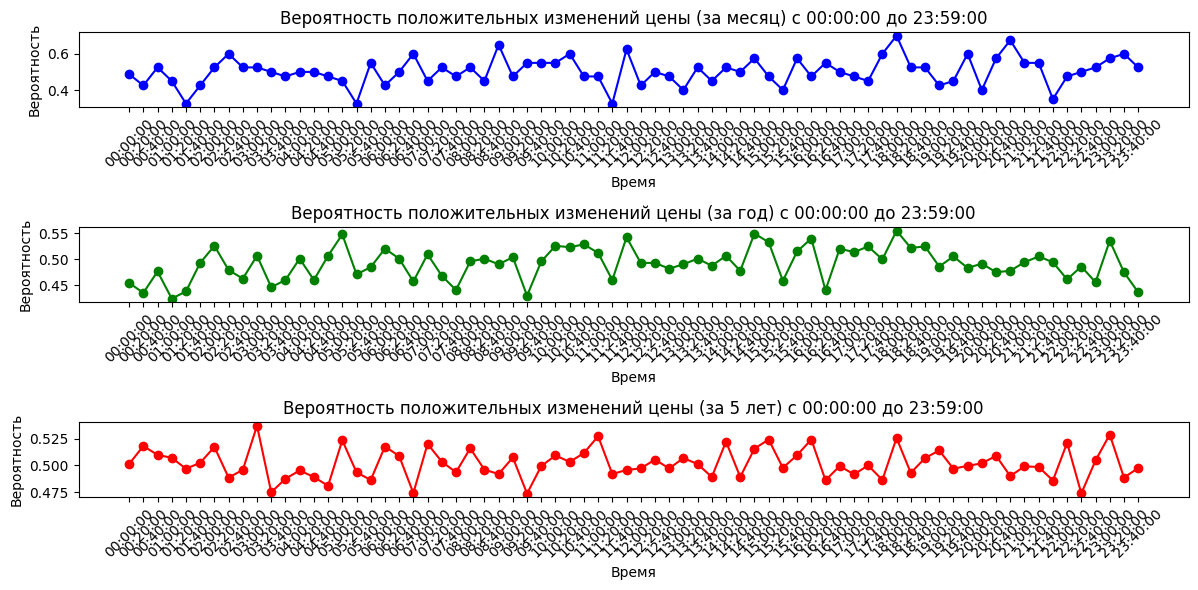

In [21]:
# Загрузите данные из CSV файла
data = pd.read_csv('D:/PyCharm/VKR/data/Probability_of_growth_2.csv')


# Создание списков времени и вероятностей положительных изменений с шагом 20 минут
times = data['Time'][::20]
positive_probabilities = data['Monthly_data'][::20]  # Используйте соответствующий столбец
# Создайте три графика в разных окнах
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(times, positive_probabilities, marker='o', linestyle='-', color='b')
plt.xlabel('Время')
plt.ylabel('Вероятность')
plt.title('Вероятность положительных изменений цены (за месяц) с 00:00:00 до 23:59:00')
plt.xticks(rotation=45)

positive_probabilities = data['Annual_data'][::20]
plt.subplot(3, 1, 2)
plt.plot(times, positive_probabilities, marker='o', linestyle='-', color='g')
plt.xlabel('Время')
plt.ylabel('Вероятность')
plt.title('Вероятность положительных изменений цены (за год) с 00:00:00 до 23:59:00')
plt.xticks(rotation=45)

positive_probabilities = data['Data_for_5_years'][::20]
plt.subplot(3, 1, 3)
plt.plot(times, positive_probabilities, marker='o', linestyle='-', color='r')
plt.xlabel('Время')
plt.ylabel('Вероятность')
plt.title('Вероятность положительных изменений цены (за 5 лет) с 00:00:00 до 23:59:00')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
так как на данных графиках мало что понятно выведем описательную статистику

In [13]:

data = pd.read_csv('D:/PyCharm/VKR/data/Probability_of_growth_2.csv')
selected_columns = ['Time', 'Monthly_data', 'Annual_data', 'Data_for_5_years']
statistics = data[selected_columns].describe()#  описательная статистистика
statistics

Monthly_data  Annual_data  Data_for_5_years
count   1440.000000  1440.000000       1440.000000
mean       0.494228     0.478644          0.493222
std        0.077871     0.028878          0.013833
min        0.250000     0.375342          0.441031
25%        0.450000     0.460274          0.484062
50%        0.500000     0.478022          0.493385
75%        0.550000     0.498630          0.502466
max        0.775000     0.568681          0.546301

In [14]:
тут явно видно что откланения и выбросы (если их так можно назвать) минимальны большая чать данных лежить в раёоне 50 %
Теперь выведем график распределения данных или график плотности

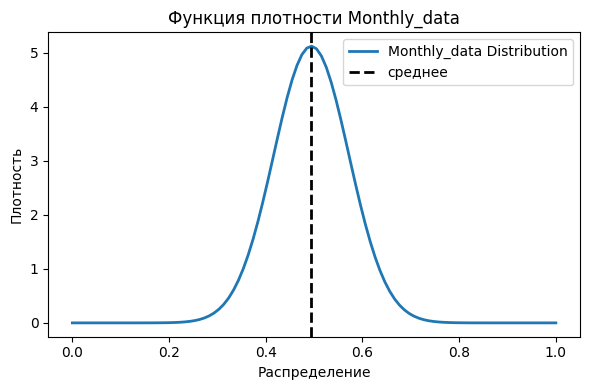

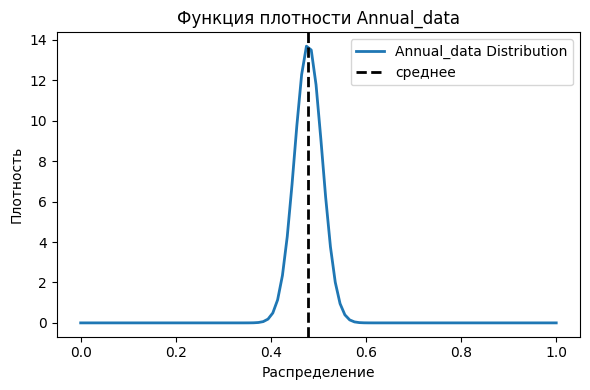

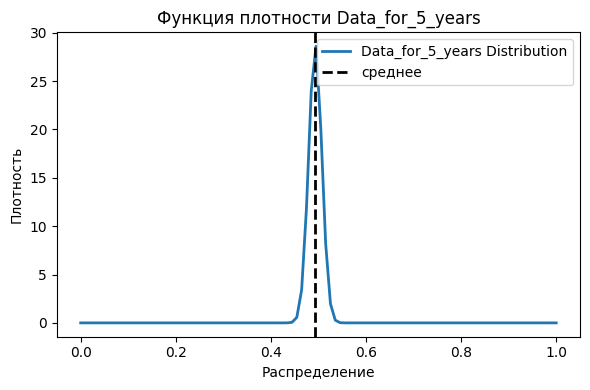

In [18]:

data = pd.read_csv('D:/PyCharm/VKR/data/Probability_of_growth_2.csv')

# Получение всех столбцов, кроме столбца 'Time'
columns_to_plot = data.columns[1:] 

# Построение графиков нормального распределения для каждого столбца
for column in columns_to_plot:

    column_data = data[column]

    # Среднее и стандартное отклонение
    mean_value = column_data.mean()
    std_dev = column_data.std()

    # Построение графика нормального распределения
    plt.figure(figsize=(6, 4))
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_value, std_dev)
    plt.plot(x, p, linewidth=2, label=f'{column} Distribution')
    plt.axvline(mean_value, color='k', linestyle='dashed', linewidth=2, label='среднее')
    plt.xlabel('Распределение')
    plt.ylabel('Плотность')
    plt.title(f'Функция плотности {column}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
Данные графики демонстрируют ярковыраженное нормальное распределение. Также можно заметить отсутствие сильных отклонений данных, 
что указывает на минимальную закономерность в изменении цен от временем суток.
в подтверждение данных словвыведем графики с верояностями боллее подробно и выделим участи отклонение от среднего распределение присудствует на всех пверемнных итервалах

C:\Users\Денис\AppData\Local\Temp\ipykernel_7076\3967784042.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time']).dt.time


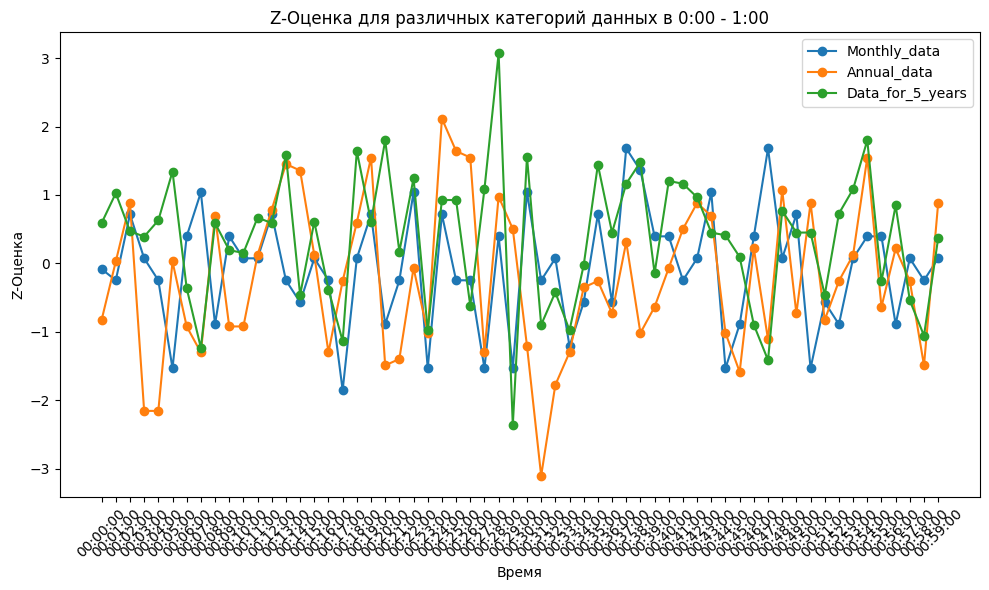

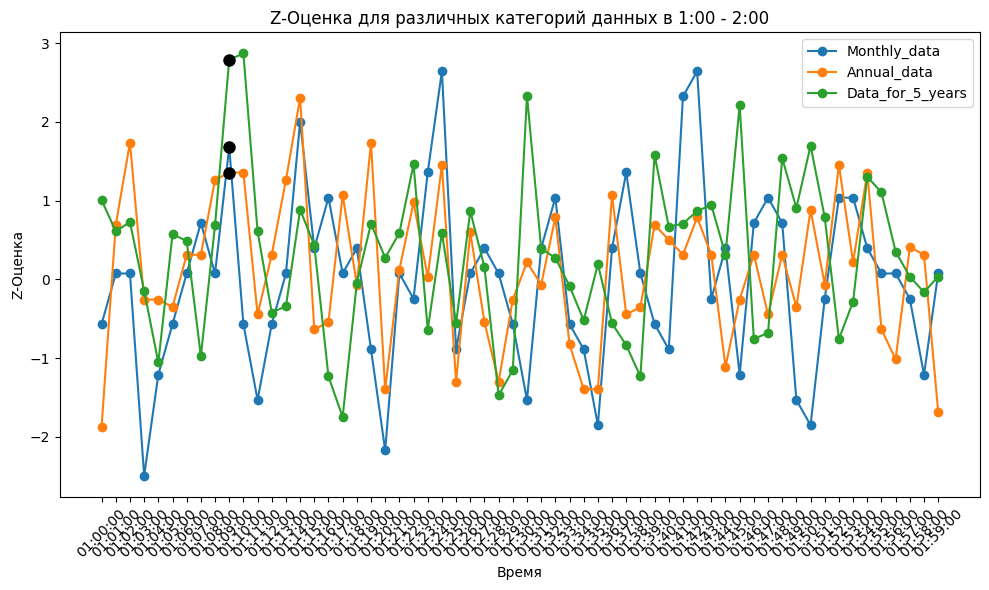

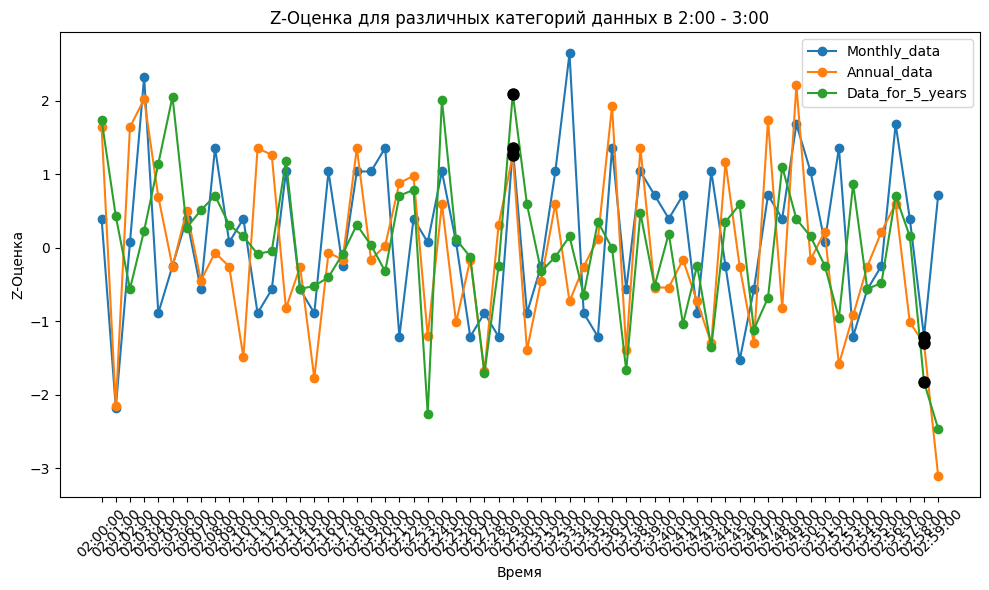

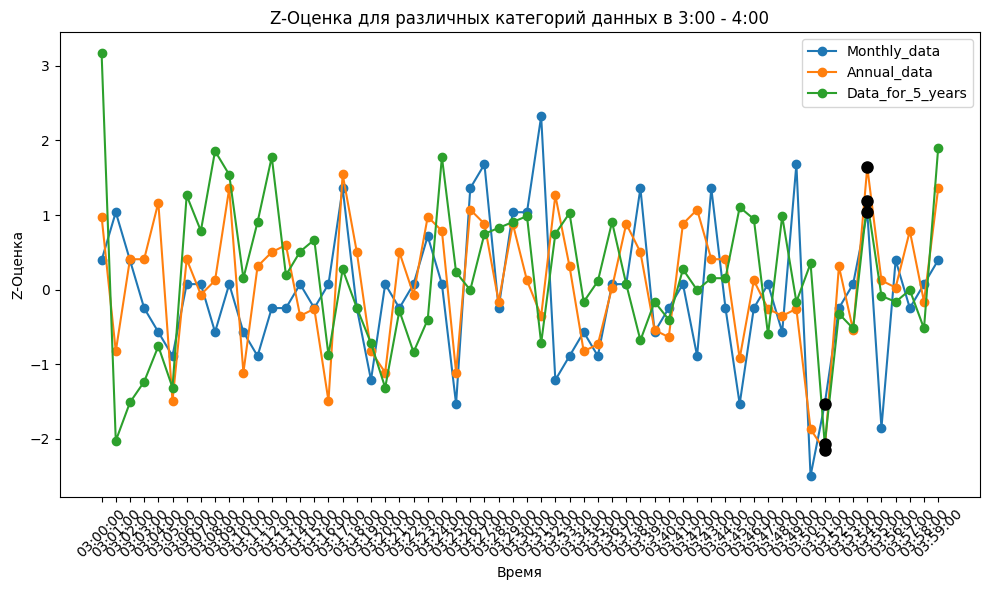

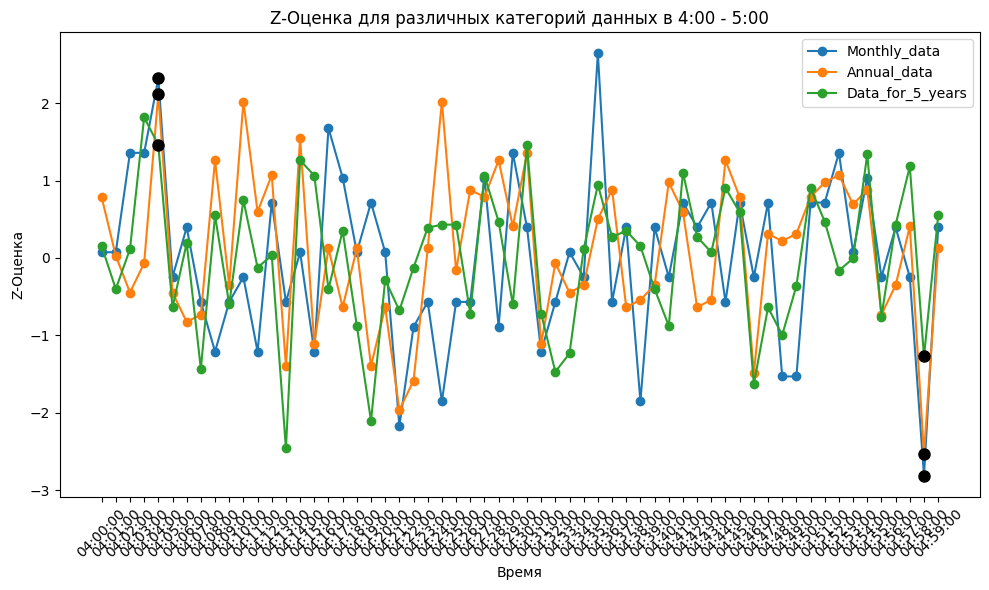

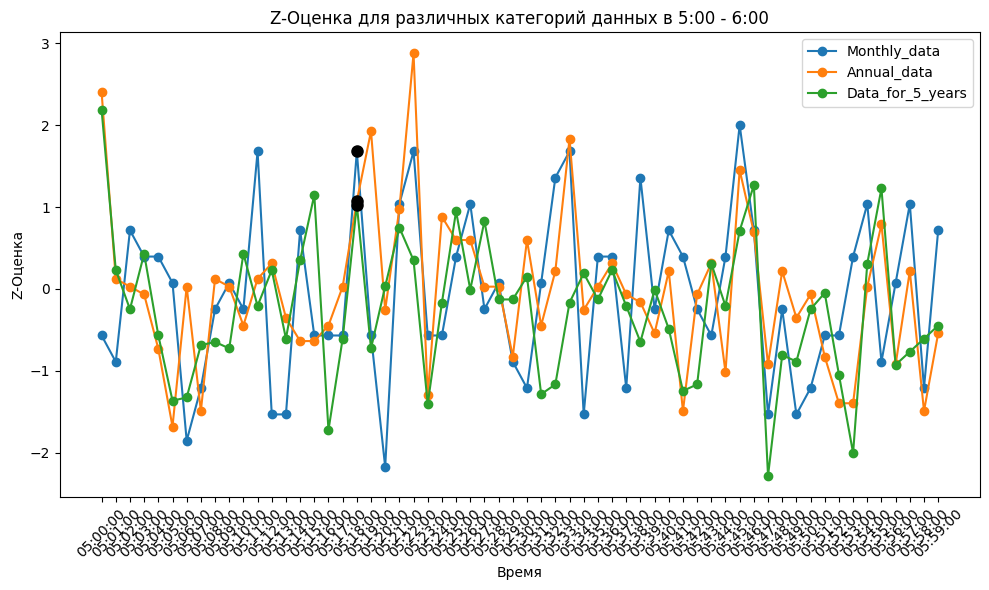

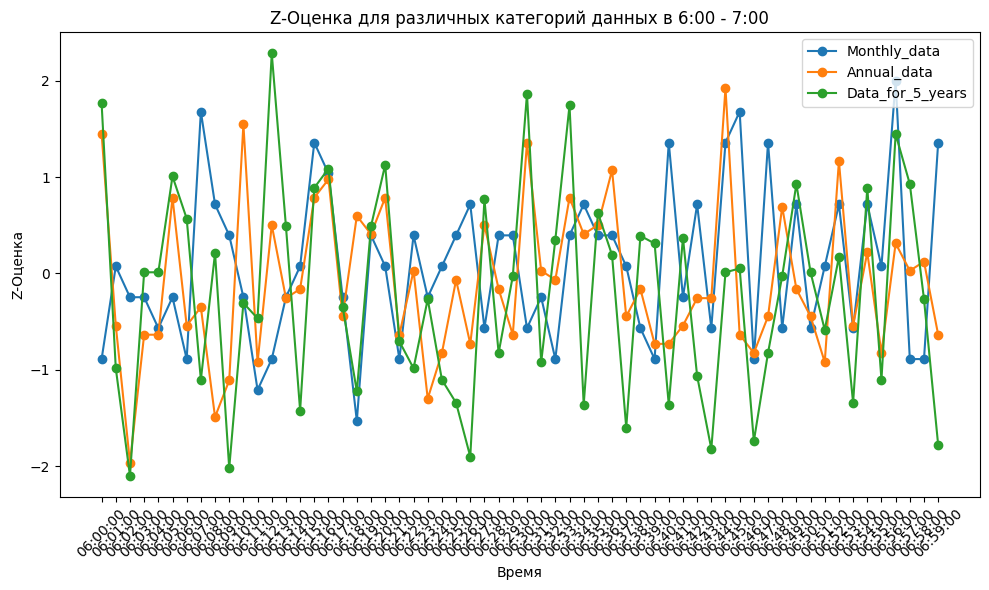

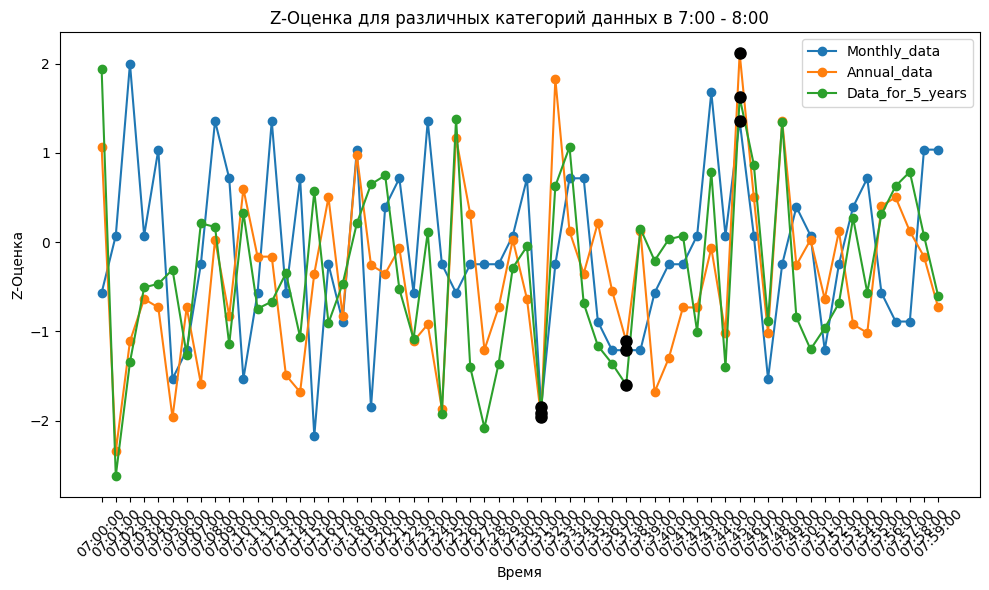

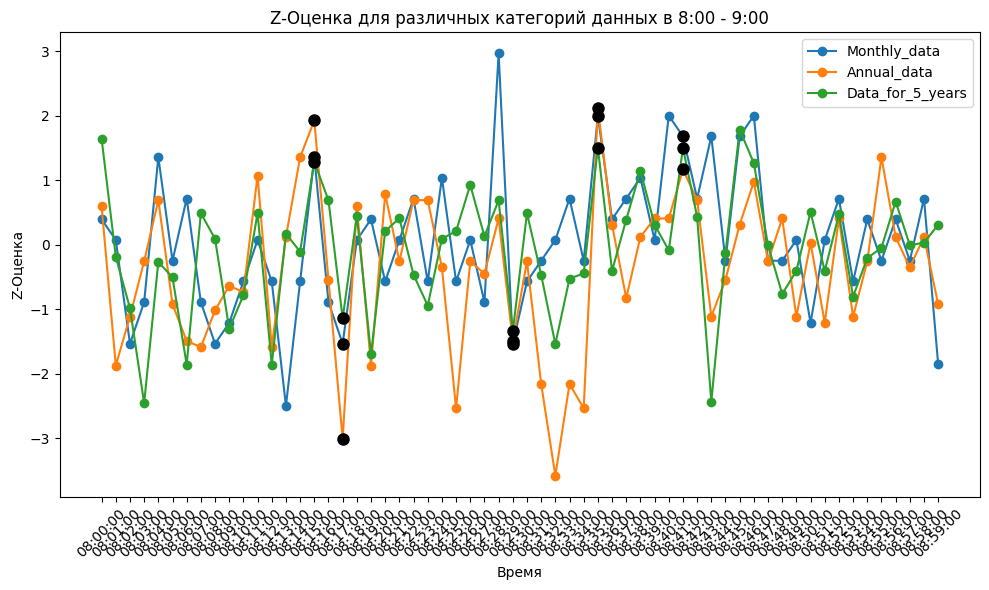

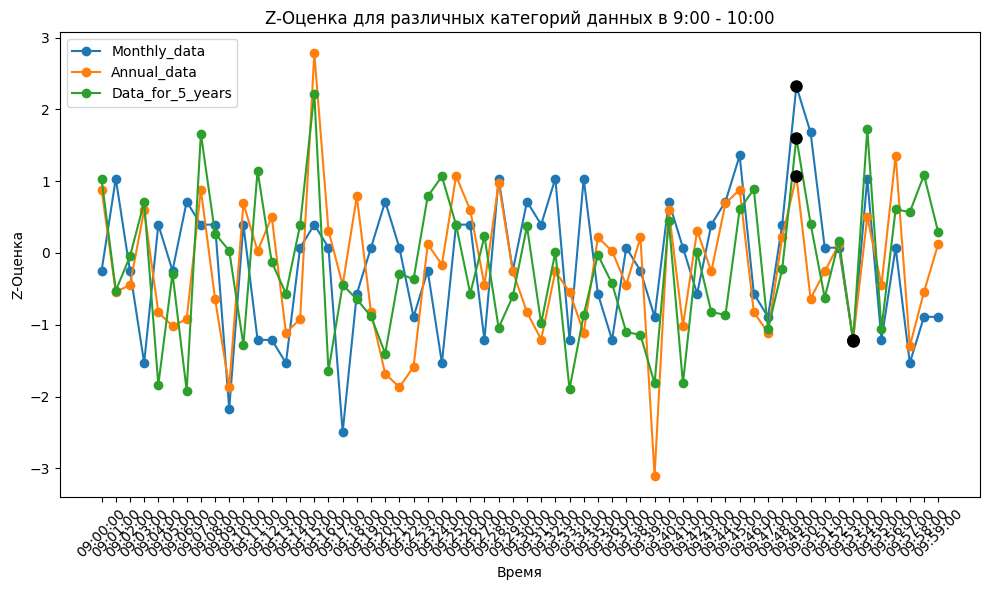

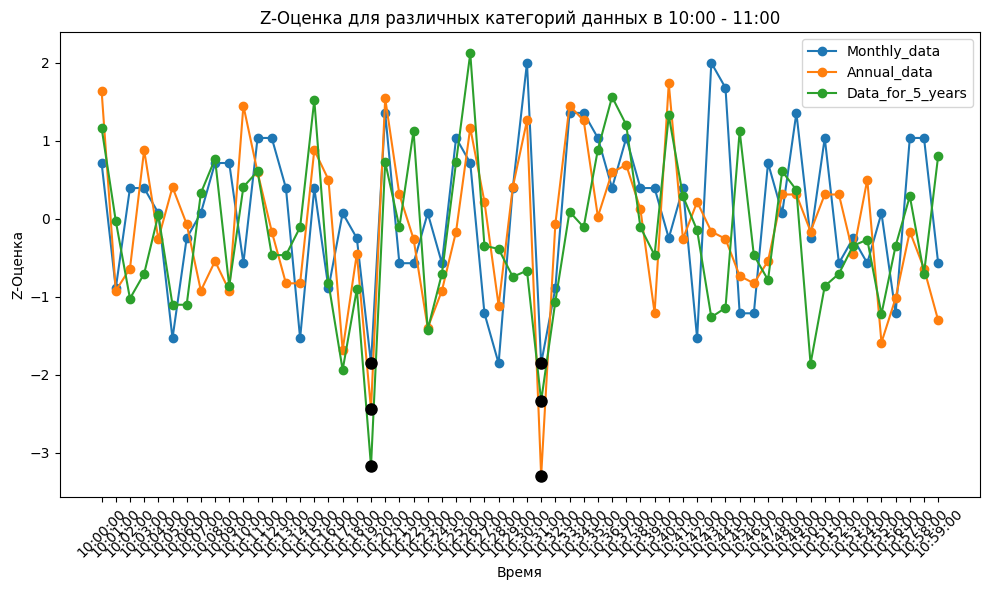

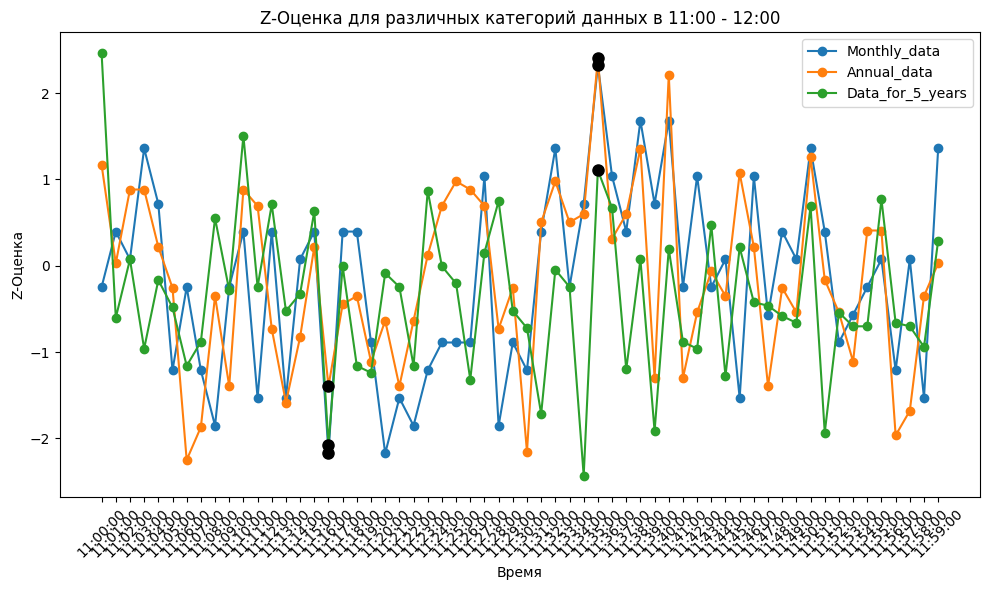

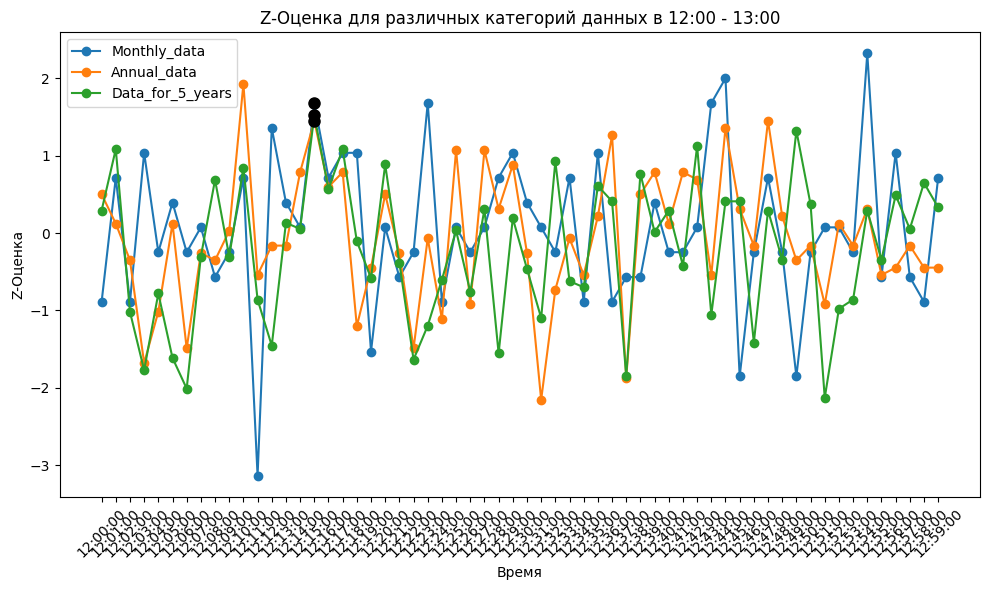

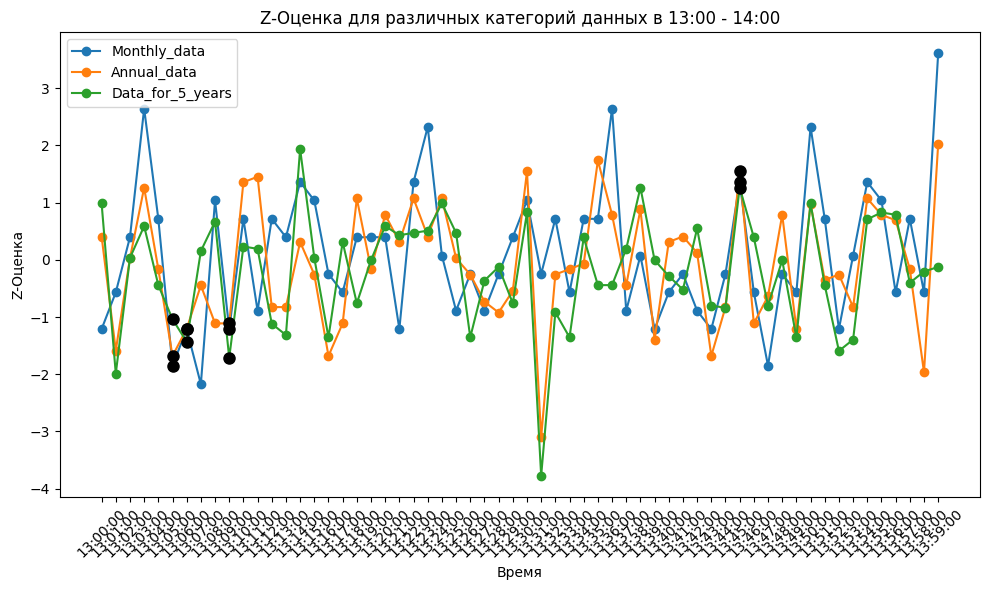

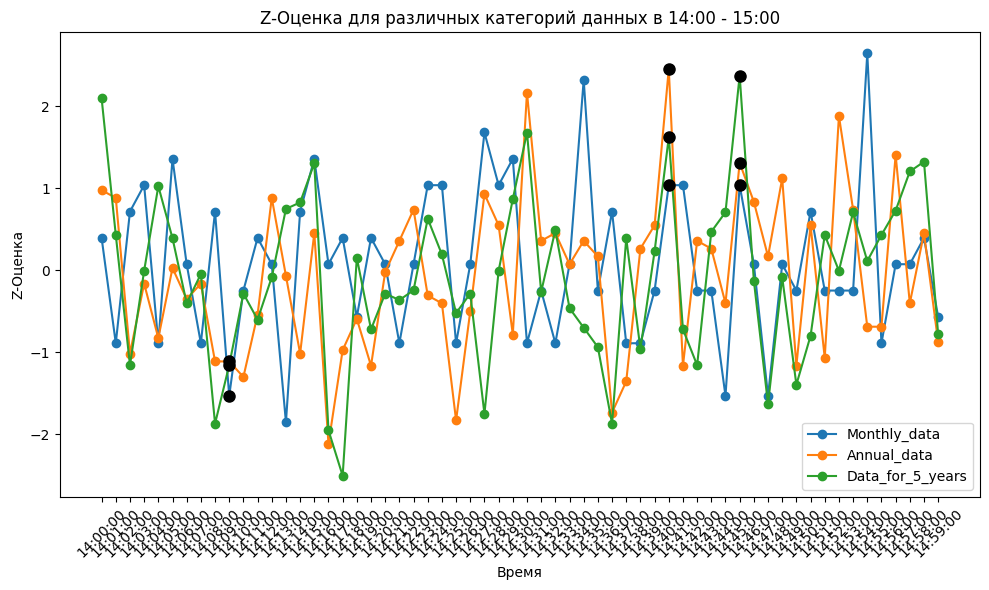

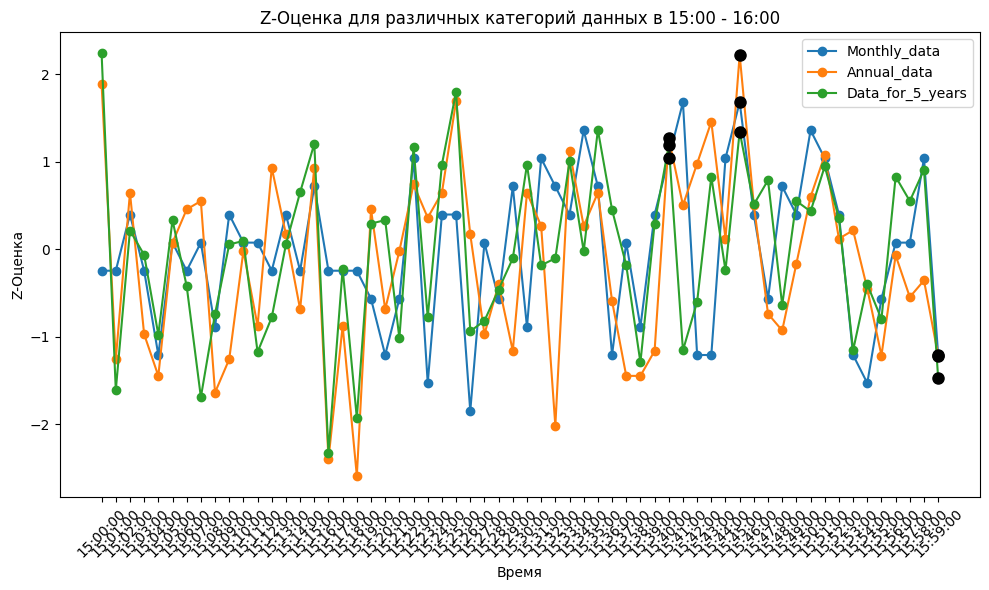

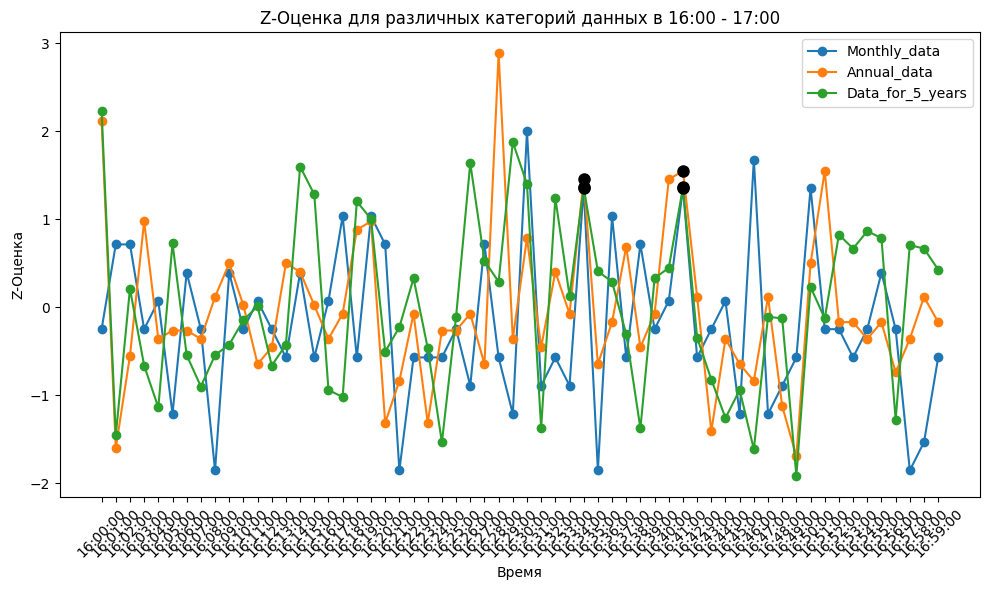

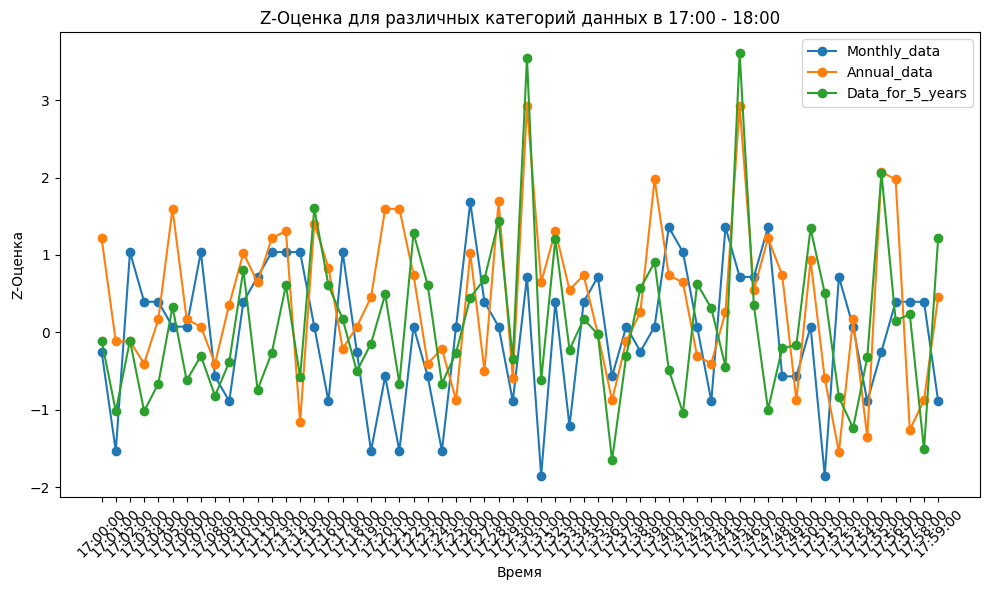

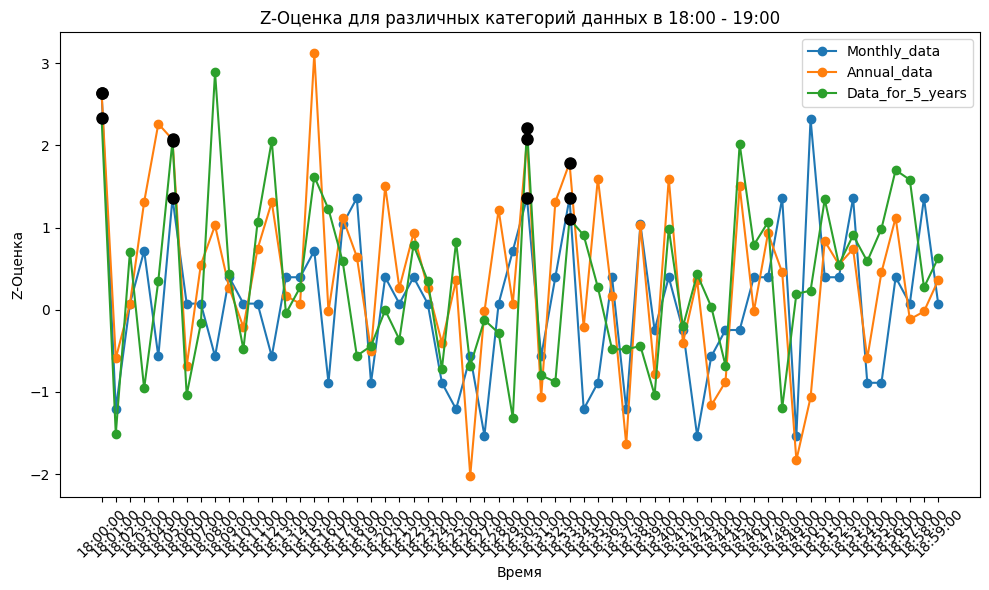

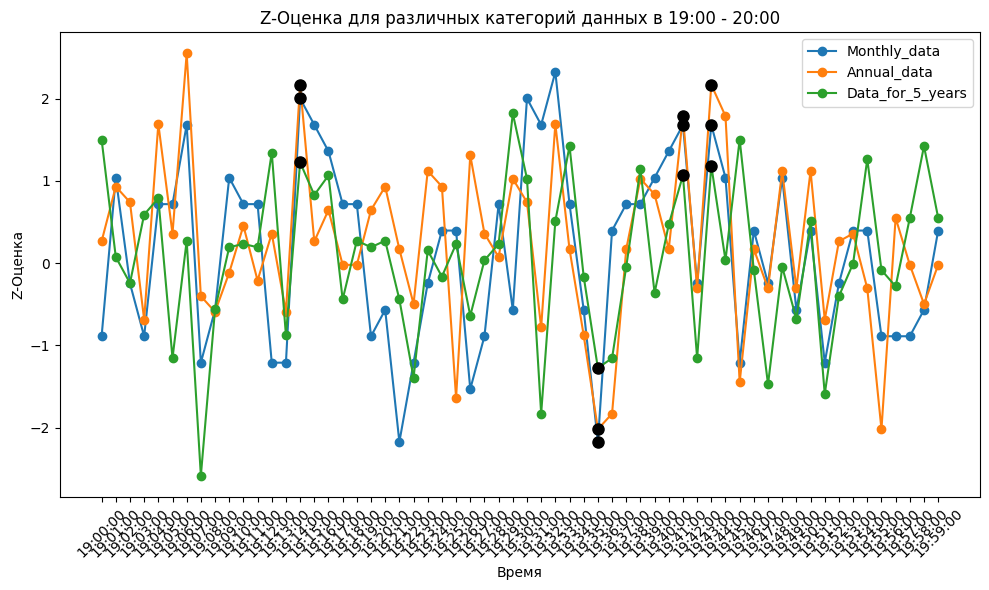

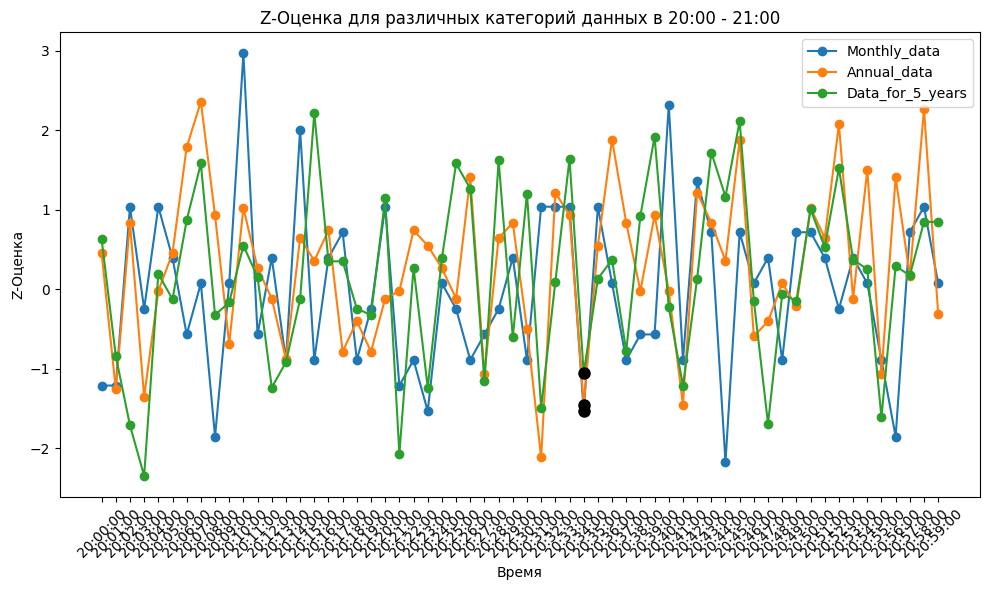

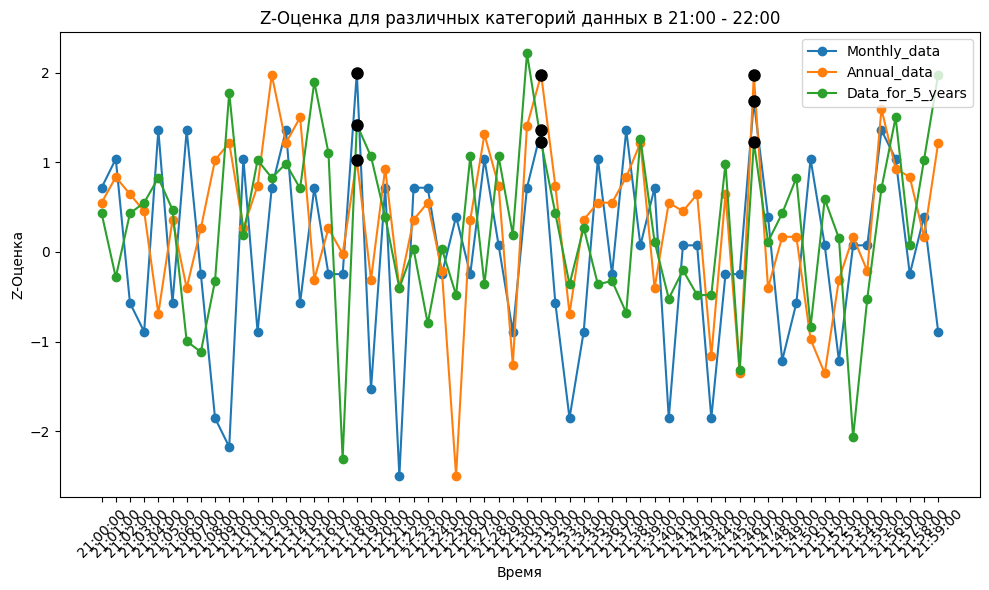

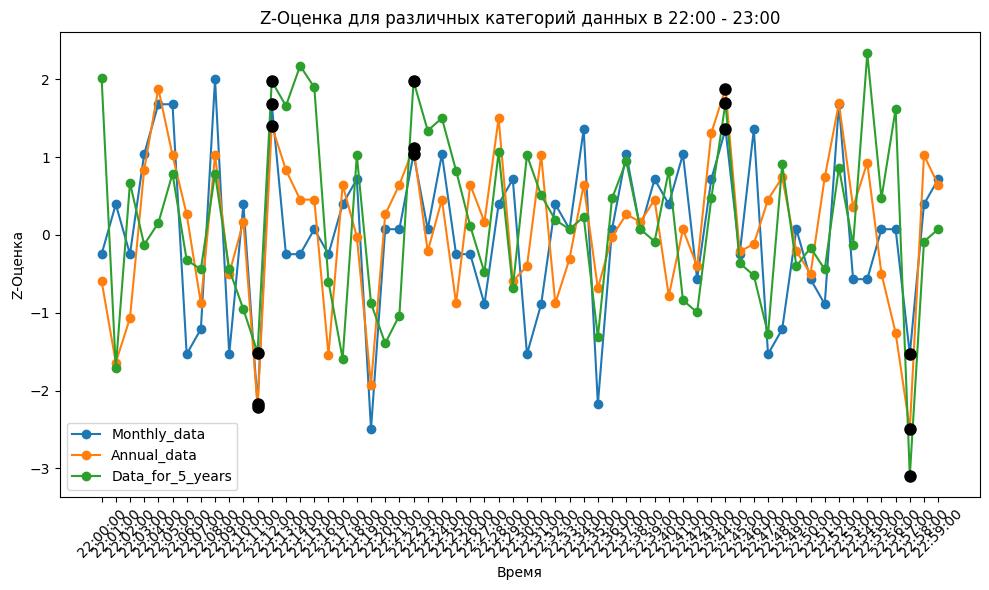

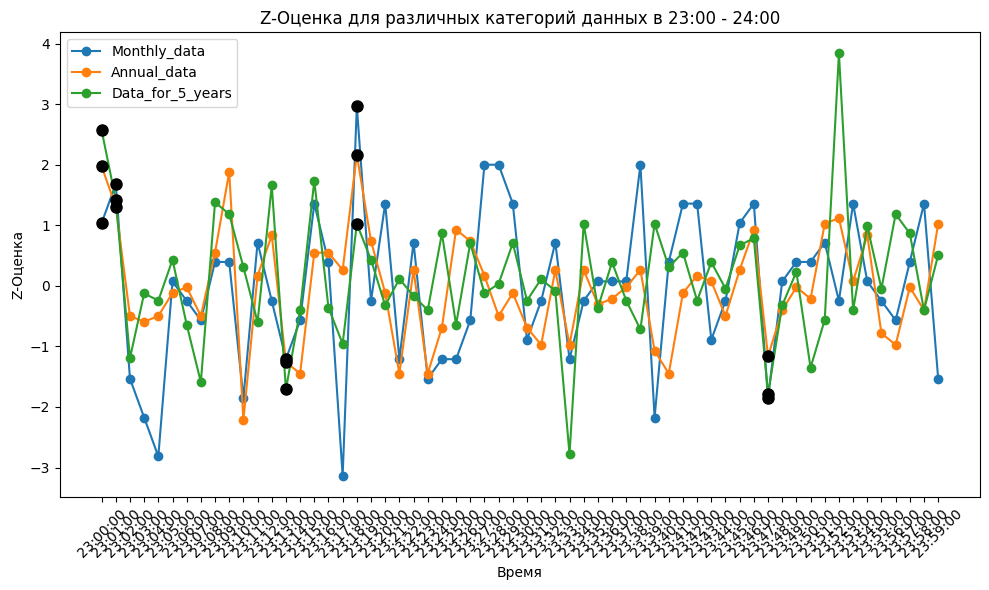

In [22]:
data = pd.read_csv('D:/PyCharm/VKR/data/Probability_of_growth_2.csv')

# преобразование объектов времени в формат datetime
data['Time'] = pd.to_datetime(data['Time']).dt.time

# преобразование объектов времени в строковый формат
data['Time'] = data['Time'].apply(lambda x: x.strftime('%H:%M:%S'))

# применение Z-оценки к данным
data_zscore = data.copy()
data_zscore[['Monthly_data', 'Annual_data', 'Data_for_5_years']] = zscore(data[['Monthly_data', 'Annual_data', 'Data_for_5_years']])

for hour in range(24):
    # Выберите данные для текущего часа
    subset = data_zscore[data['Time'].str.startswith(f'{hour:02}')]

    # провекра, все ли три точки больше 2 или меньше -2
    x = 1
    subset_filtered = subset[
        (subset['Monthly_data'] > x) & (subset['Annual_data'] > x) & (subset['Data_for_5_years'] > x) |
        (subset['Monthly_data'] < -x) & (subset['Annual_data'] < -x) & (subset['Data_for_5_years'] < -x)
    ]

    # посторение график для текущего часа
    plt.figure(figsize=(10, 6))
    plt.plot(subset['Time'], subset['Monthly_data'], marker='o', label='Monthly_data')
    plt.plot(subset['Time'], subset['Annual_data'], marker='o', label='Annual_data')
    plt.plot(subset['Time'], subset['Data_for_5_years'], marker='o', label='Data_for_5_years')

    # пометка точек, удовлетворяющих условиям
    if not subset_filtered.empty:
        plt.plot(subset_filtered['Time'], subset_filtered['Monthly_data'], marker='o', linestyle='None', color='black', markersize=8)
        plt.plot(subset_filtered['Time'], subset_filtered['Annual_data'], marker='o', linestyle='None', color='black', markersize=8)
        plt.plot(subset_filtered['Time'], subset_filtered['Data_for_5_years'], marker='o', linestyle='None', color='black', markersize=8)

    plt.xlabel('Время')
    plt.ylabel('Z-Оценка')
    plt.title(f'Z-Оценка для различных категорий данных в {hour}:00 - {hour + 1}:00')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
скомпануем все выделенные участки на один график 

C:\Users\Денис\AppData\Local\Temp\ipykernel_12764\1693915324.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time']).dt.time


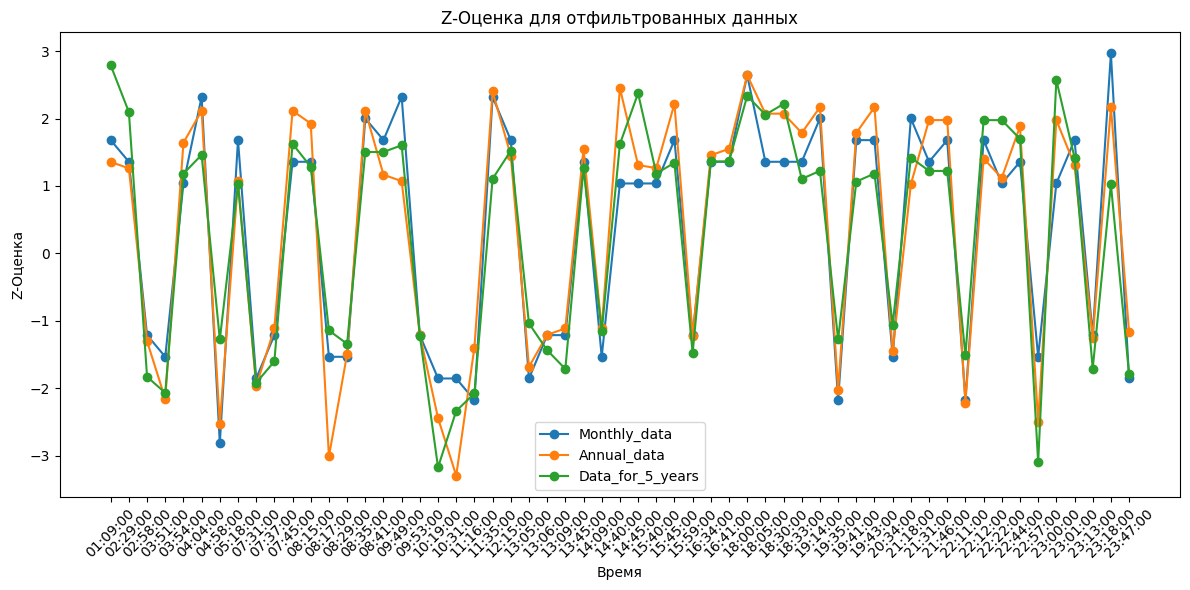

In [5]:
# Загрузите данные из CSV-файла
data = pd.read_csv('D:/PyCharm/VKR/data/Probability_of_growth_2.csv')

# преобразование объектов времени в формат datetime
data['Time'] = pd.to_datetime(data['Time']).dt.time

# преобразование объектов времени в строковый формат
data['Time'] = data['Time'].apply(lambda x: x.strftime('%H:%M:%S'))

# применение Z-оценки к данным
data_zscore = data.copy()
data_zscore[['Monthly_data', 'Annual_data', 'Data_for_5_years']] = zscore(data[['Monthly_data', 'Annual_data', 'Data_for_5_years']])

# Пустой DataFrame для хранения отфильтрованных данных
filtered_data = pd.DataFrame()

for hour in range(24):
    # данные для текущего часа
    subset = data_zscore[data['Time'].str.startswith(f'{hour:02}')]

    # проверка, все три точки больше 2 или меньше -2
    x = 1
    subset_filtered = subset[
        (subset['Monthly_data'] > x) & (subset['Annual_data'] > x) & (subset['Data_for_5_years'] > x) |
        (subset['Monthly_data'] < -x) & (subset['Annual_data'] < -x) & (subset['Data_for_5_years'] < -x)
    ]

    # добавление отфильтрованных данных в DataFrame
    filtered_data = pd.concat([filtered_data, subset_filtered])

# построение графика для отфильтрованных данных
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Time'], filtered_data['Monthly_data'], marker='o', label='Monthly_data')
plt.plot(filtered_data['Time'], filtered_data['Annual_data'], marker='o', label='Annual_data')
plt.plot(filtered_data['Time'], filtered_data['Data_for_5_years'], marker='o', label='Data_for_5_years')

plt.xlabel('Время')
plt.ylabel('Z-Оценка')
plt.title('Z-Оценка для отфильтрованных данных')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
Анализ наложенных друг на друга графиков различных временных интервалов позволяет выявить закономерности в динамике цен в течение дня. 
Эта выявленная закономерность может быть ключом к созданию более точных прогностических моделей. 
Мы можем использовать эту закономерность в виде коэффициента для улучшения точности наших прогнозов о ценах в будущем. 
Анализируя динамику цен в разные часы дня, мы можем выделить определенные временные интервалы, в которых цены чаще всего растут или падают. 
Эти наблюдения могут быть использованы для более эффективного управления рисками и повышения точности наших прогнозов, 
что в конечном итоге способствует более успешным инвестициям и финансовым решениям.

Epoch 1/60
1067/1067 - 5s - loss: 0.0064 - 5s/epoch - 4ms/step
Epoch 2/60
1067/1067 - 4s - loss: 2.2649e-05 - 4s/epoch - 3ms/step
Epoch 3/60
1067/1067 - 3s - loss: 2.2663e-05 - 3s/epoch - 3ms/step
Epoch 4/60
1067/1067 - 4s - loss: 2.0035e-05 - 4s/epoch - 3ms/step
Epoch 5/60
1067/1067 - 4s - loss: 1.5522e-05 - 4s/epoch - 3ms/step
Epoch 6/60
1067/1067 - 4s - loss: 1.6845e-05 - 4s/epoch - 3ms/step
Epoch 7/60
1067/1067 - 3s - loss: 1.6372e-05 - 3s/epoch - 3ms/step
Epoch 8/60
1067/1067 - 4s - loss: 1.5987e-05 - 4s/epoch - 3ms/step
Epoch 9/60
1067/1067 - 4s - loss: 1.4906e-05 - 4s/epoch - 4ms/step
Epoch 10/60
1067/1067 - 4s - loss: 1.4684e-05 - 4s/epoch - 4ms/step
Epoch 11/60
1067/1067 - 4s - loss: 1.4367e-05 - 4s/epoch - 4ms/step
Epoch 12/60
1067/1067 - 4s - loss: 1.3363e-05 - 4s/epoch - 3ms/step
Epoch 13/60
1067/1067 - 3s - loss: 1.3869e-05 - 3s/epoch - 3ms/step
Epoch 14/60
1067/1067 - 4s - loss: 1.2253e-05 - 4s/epoch - 3ms/step
Epoch 15/60
1067/1067 - 3s - loss: 1.2118e-05 - 3s/epoch - 3m

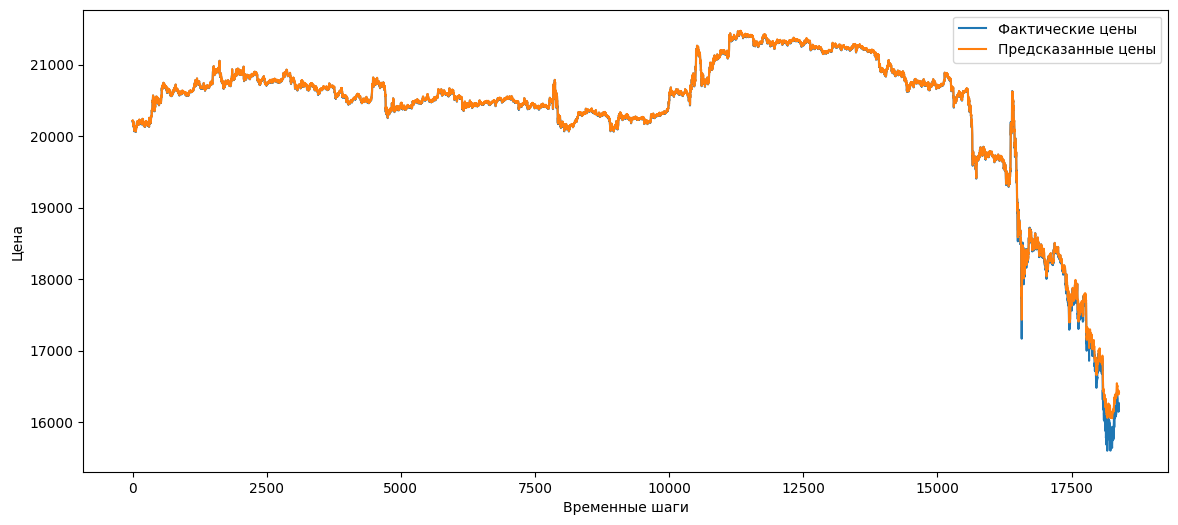

In [7]:
# Загрузка данных из CSV файла
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices_2_modified.csv')
prices = data['Price'].values.reshape(-1, 1)

# Нормализация данных в диапазоне от 0 до 1
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Создание последовательности для LSTM модели
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10  # Количество временных шагов для каждой последовательности
X, y = create_sequences(prices_scaled, n_steps)

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создание LSTM модели
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Обучение модели
history = model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=2)

# Предсказание цен на тестовом наборе
predicted_prices = model.predict(X_test)

# Инвертирование нормализации для предсказанных значений
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Расчет и вывод ошибки модели
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicted_prices)
print(f'Среднеквадратичная ошибка модели: {mse}')

# Визуализация результатов
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Фактические цены')
plt.plot(predicted_prices, label='Предсказанные цены')
plt.xlabel('Временные шаги')
plt.ylabel('Цена')
plt.legend()
plt.savefig('Graf.png')
plt.show()

In [ ]:
1872.622683761716 данная квадратичная ошибка довольно велика хотя общий тренд модель улавливает  

In [ ]:
попробуем другую модель GRU и посмотрим на результат

Epoch 1/60
1067/1067 - 9s - loss: 0.0066 - 9s/epoch - 9ms/step
Epoch 2/60
1067/1067 - 8s - loss: 1.2382e-05 - 8s/epoch - 8ms/step
Epoch 3/60
1067/1067 - 8s - loss: 1.1224e-05 - 8s/epoch - 8ms/step
Epoch 4/60
1067/1067 - 8s - loss: 1.0489e-05 - 8s/epoch - 8ms/step
Epoch 5/60
1067/1067 - 8s - loss: 1.0060e-05 - 8s/epoch - 8ms/step
Epoch 6/60
1067/1067 - 8s - loss: 9.1386e-06 - 8s/epoch - 8ms/step
Epoch 7/60
1067/1067 - 8s - loss: 8.6551e-06 - 8s/epoch - 8ms/step
Epoch 8/60
1067/1067 - 9s - loss: 7.8193e-06 - 9s/epoch - 8ms/step
Epoch 9/60
1067/1067 - 8s - loss: 7.2351e-06 - 8s/epoch - 8ms/step
Epoch 10/60
1067/1067 - 8s - loss: 7.3879e-06 - 8s/epoch - 8ms/step
Epoch 11/60
1067/1067 - 8s - loss: 6.7261e-06 - 8s/epoch - 8ms/step
Epoch 12/60
1067/1067 - 9s - loss: 7.0614e-06 - 9s/epoch - 8ms/step
Epoch 13/60
1067/1067 - 9s - loss: 6.2807e-06 - 9s/epoch - 8ms/step
Epoch 14/60
1067/1067 - 9s - loss: 6.3841e-06 - 9s/epoch - 8ms/step
Epoch 15/60
1067/1067 - 9s - loss: 6.1639e-06 - 9s/epoch - 8m

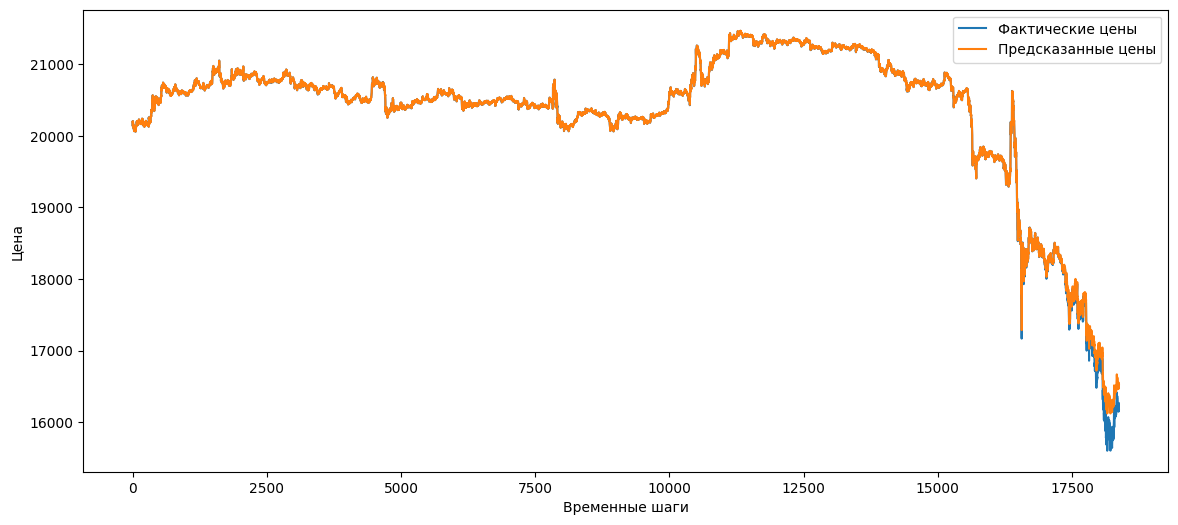

D:\PyCharm\VKR\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Загрузка данных из CSV файла
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices_2_modified.csv')
prices = data['Price'].values.reshape(-1, 1)

# Нормализация данных в диапазоне от 0 до 1
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Создание последовательности для GRU модели
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 30  # Количество временных шагов для каждой последовательности
X, y = create_sequences(prices_scaled, n_steps)

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создание GRU модели
model = Sequential()
model.add(GRU(60, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Обучение модели
model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=2)

# Предсказание цен на тестовом наборе
predicted_prices = model.predict(X_test)

# Инвертирование нормализации для предсказанных значений
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Оценка качества модели
mse = mean_squared_error(y_test, predicted_prices)
print(f'Среднеквадратичная ошибка модели GRU: {mse:.2f}')

# Визуализация результатов
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Фактические цены')
plt.plot(predicted_prices, label='Предсказанные цены')
plt.xlabel('Временные шаги')
plt.ylabel('Цена')
plt.legend()
plt.savefig('predicted_prices_gru.png')
plt.show()

# Сохранение модели
model.save('gru_model.h5')

Epoch 1/60
1067/1067 - 3s - loss: 0.0010 - 3s/epoch - 2ms/step
Epoch 2/60
1067/1067 - 2s - loss: 1.6206e-05 - 2s/epoch - 2ms/step
Epoch 3/60
1067/1067 - 2s - loss: 1.9435e-05 - 2s/epoch - 2ms/step
Epoch 4/60
1067/1067 - 2s - loss: 2.2458e-05 - 2s/epoch - 2ms/step
Epoch 5/60
1067/1067 - 2s - loss: 2.3592e-05 - 2s/epoch - 2ms/step
Epoch 6/60
1067/1067 - 2s - loss: 2.4666e-05 - 2s/epoch - 2ms/step
Epoch 7/60
1067/1067 - 3s - loss: 2.2208e-05 - 3s/epoch - 2ms/step
Epoch 8/60
1067/1067 - 3s - loss: 2.2194e-05 - 3s/epoch - 3ms/step
Epoch 9/60
1067/1067 - 3s - loss: 1.9853e-05 - 3s/epoch - 3ms/step
Epoch 10/60
1067/1067 - 2s - loss: 2.0436e-05 - 2s/epoch - 2ms/step
Epoch 11/60
1067/1067 - 2s - loss: 2.0673e-05 - 2s/epoch - 2ms/step
Epoch 12/60
1067/1067 - 2s - loss: 1.8558e-05 - 2s/epoch - 2ms/step
Epoch 13/60
1067/1067 - 2s - loss: 1.7280e-05 - 2s/epoch - 2ms/step
Epoch 14/60
1067/1067 - 2s - loss: 1.8090e-05 - 2s/epoch - 2ms/step
Epoch 15/60
1067/1067 - 3s - loss: 1.6892e-05 - 3s/epoch - 2m

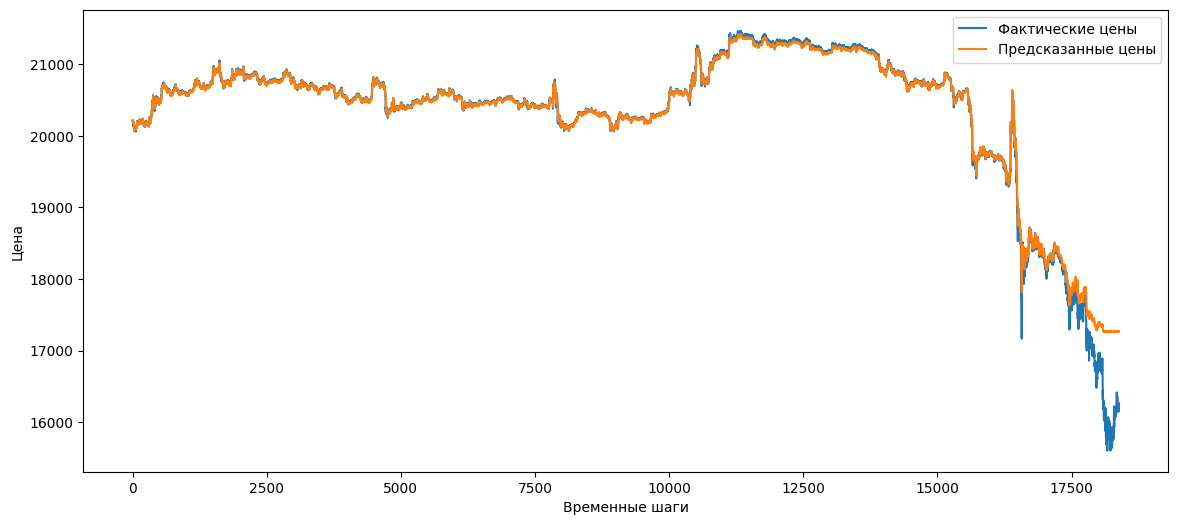

D:\PyCharm\VKR\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Загрузка данных из CSV файла
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices_2_modified.csv')
prices = data['Price'].values.reshape(-1, 1)

# Нормализация данных в диапазоне от 0 до 1
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Создание последовательности для CNN модели
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10  # Количество временных шагов для каждой последовательности
X, y = create_sequences(prices_scaled, n_steps)

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создание CNN модели
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# Обучение модели
model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=2)

# Предсказание цен на тестовом наборе
predicted_prices = model.predict(X_test)

# Инвертирование нормализации для предсказанных значений
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Оценка качества модели
mse = mean_squared_error(y_test, predicted_prices)
print(f'Среднеквадратичная ошибка модели CNN: {mse:.2f}')

# Визуализация результатов
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Фактические цены')
plt.plot(predicted_prices, label='Предсказанные цены')
plt.xlabel('Временные шаги')
plt.ylabel('Цена')
plt.legend()
plt.show()

# Сохранение модели
model.save('cnn_model.h5')

In [ ]:
как видно из ошибки наилудший результат показала модель LSTM.
Попробуем обучить модель LSTM на большем объеме данных

Epoch 1/60
10663/10663 - 37s - loss: 4.1898e-04 - 37s/epoch - 4ms/step
Epoch 2/60
10663/10663 - 36s - loss: 4.5291e-06 - 36s/epoch - 3ms/step
Epoch 3/60
10663/10663 - 36s - loss: 3.3319e-06 - 36s/epoch - 3ms/step
Epoch 4/60
10663/10663 - 36s - loss: 2.4927e-06 - 36s/epoch - 3ms/step
Epoch 5/60
10663/10663 - 35s - loss: 2.0599e-06 - 35s/epoch - 3ms/step
Epoch 6/60
10663/10663 - 35s - loss: 1.8037e-06 - 35s/epoch - 3ms/step
Epoch 7/60
10663/10663 - 34s - loss: 1.6736e-06 - 34s/epoch - 3ms/step
Epoch 8/60
10663/10663 - 35s - loss: 1.5582e-06 - 35s/epoch - 3ms/step
Epoch 9/60
10663/10663 - 35s - loss: 1.3535e-06 - 35s/epoch - 3ms/step
Epoch 10/60
10663/10663 - 34s - loss: 1.3025e-06 - 34s/epoch - 3ms/step
Epoch 11/60
10663/10663 - 35s - loss: 1.2436e-06 - 35s/epoch - 3ms/step
Epoch 12/60
10663/10663 - 34s - loss: 1.2093e-06 - 34s/epoch - 3ms/step
Epoch 13/60
10663/10663 - 34s - loss: 1.2029e-06 - 34s/epoch - 3ms/step
Epoch 14/60
10663/10663 - 36s - loss: 1.1939e-06 - 36s/epoch - 3ms/step
E

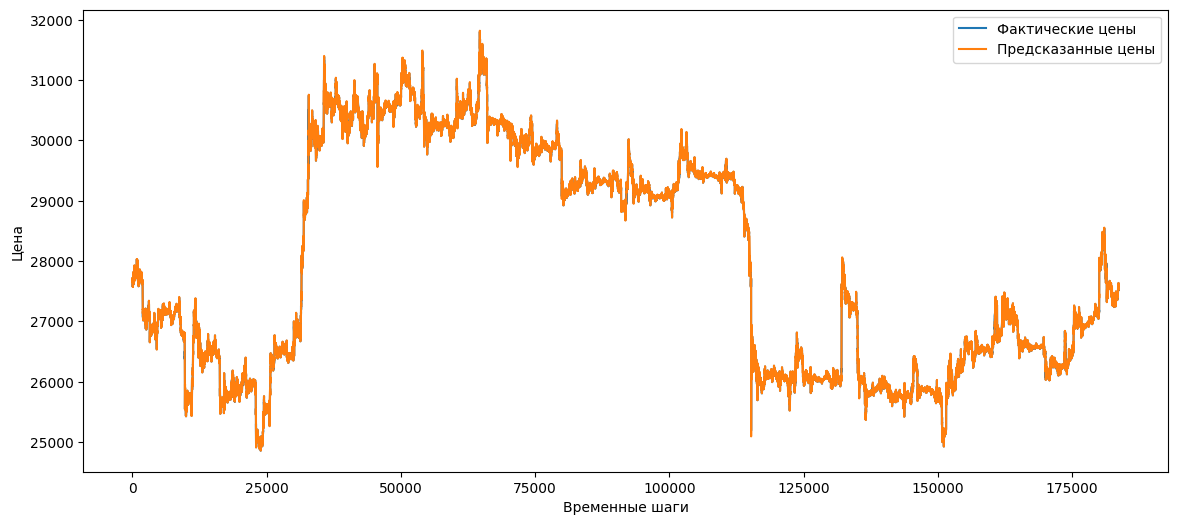

In [17]:
# Загрузка данных из CSV файла
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices.csv')
prices = data['Price'].values.reshape(-1, 1)

# Нормализация данных в диапазоне от 0 до 1
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Создание последовательности для LSTM модели
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10  # Количество временных шагов для каждой последовательности
X, y = create_sequences(prices_scaled, n_steps)

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создание LSTM модели
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Обучение модели
history = model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=2)

# Предсказание цен на тестовом наборе
predicted_prices = model.predict(X_test)

# Инвертирование нормализации для предсказанных значений
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Расчет и вывод ошибки модели
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicted_prices)
print(f'Среднеквадратичная ошибка модели: {mse}')

# Визуализация результатов
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Фактические цены')
plt.plot(predicted_prices, label='Предсказанные цены')
plt.xlabel('Временные шаги')
plt.ylabel('Цена')
plt.legend()
plt.savefig('Graf.png')
plt.show()

Epoch 1/60
53282/53282 - 176s - loss: 5.6343e-05 - 176s/epoch - 3ms/step
Epoch 2/60
53282/53282 - 175s - loss: 8.4051e-07 - 175s/epoch - 3ms/step
Epoch 3/60
53282/53282 - 170s - loss: 6.5147e-07 - 170s/epoch - 3ms/step
Epoch 4/60
53282/53282 - 169s - loss: 5.8454e-07 - 169s/epoch - 3ms/step
Epoch 5/60
53282/53282 - 169s - loss: 5.4539e-07 - 169s/epoch - 3ms/step
Epoch 6/60
53282/53282 - 169s - loss: 5.2168e-07 - 169s/epoch - 3ms/step
Epoch 7/60
53282/53282 - 169s - loss: 5.0462e-07 - 169s/epoch - 3ms/step
Epoch 8/60
53282/53282 - 169s - loss: 4.7830e-07 - 169s/epoch - 3ms/step
Epoch 9/60
53282/53282 - 180s - loss: 4.2468e-07 - 180s/epoch - 3ms/step
Epoch 10/60
53282/53282 - 183s - loss: 4.0521e-07 - 183s/epoch - 3ms/step
Epoch 11/60
53282/53282 - 177s - loss: 4.0024e-07 - 177s/epoch - 3ms/step
Epoch 12/60
53282/53282 - 181s - loss: 4.0005e-07 - 181s/epoch - 3ms/step
Epoch 13/60
53282/53282 - 178s - loss: 3.9322e-07 - 178s/epoch - 3ms/step
Epoch 14/60
53282/53282 - 188s - loss: 3.8955e-

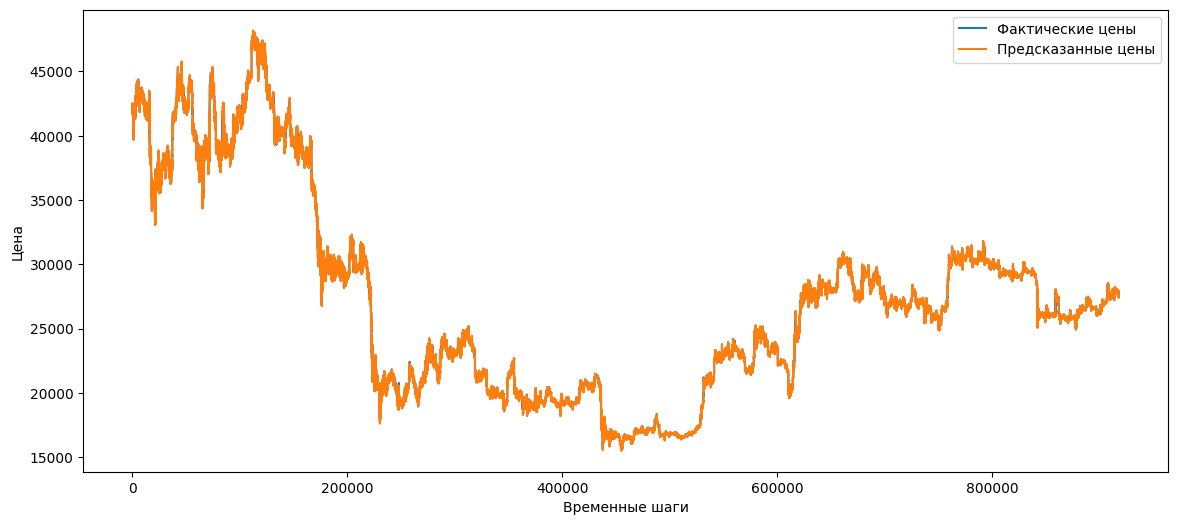

D:\PyCharm\VKR\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# Загрузка данных из CSV файла
data = pd.read_csv('D:/PyCharm/VKR/data/bitcoin_prices_five_years.csv')
prices = data['Price'].values.reshape(-1, 1)

# Нормализация данных в диапазоне от 0 до 1
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Создание последовательности для LSTM модели
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10  # Количество временных шагов для каждой последовательности
X, y = create_sequences(prices_scaled, n_steps)

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создание LSTM модели
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Обучение модели
history = model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=2)

# Предсказание цен на тестовом наборе
predicted_prices = model.predict(X_test)

# Инвертирование нормализации для предсказанных значений
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Рассчитывание и вывод ошибки модели
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicted_prices)
print(f'Среднеквадратичная ошибка модели: {mse}')

# Визуализация результатов
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Фактические цены')
plt.plot(predicted_prices, label='Предсказанные цены')
plt.xlabel('Временные шаги')
plt.ylabel('Цена')
plt.legend()
plt.savefig('Graf.png')
plt.show()
model.save('LSTM_model.h5')